# Introduction to Recommendation systems

In this modern world we are overloaded with data and this data provides us the useful information. But it's not possible for the user to extract the information which interest them from these data. In order to help the user to find out information about the product , recommedation systems where developed.

Recommeder system creates a similarity between the user and items and exploits the similarity between user/item to make recommendations.

What recommeder system can solve ?

It can help the user to find the right product.
It can increase the user engagement. For example, there's 40% more click on the google news due to recommendation.
It helps the item providers to deliver the items to the right user.In Amazon , 35 % products get sold due to recommendation.
It helps to make the contents more personalized.In Netflix most of the rented movies are from recommendations.

# Types of recommendations
There are mainly 6 types of the recommendations systems :-

Popularity based systems :- It works by recommeding items viewed and purchased by most people and are rated high.It is not a personalized recommendation.

Classification model based:- It works by understanding the features of the user and applying the classification algorithm to decide whether the user is interested or not in the prodcut.

Content based recommedations:- It is based on the information on the contents of the item rather than on the user opinions.The main idea is if the user likes an item then he or she will like the "other" similar item.

Collaberative Filtering:- It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types: a) User-User b) Item -Item

Hybrid Approaches:- This system approach is to combine collaborative filtering, content-based filtering, and other approaches .

Association rule mining :- Association rules capture the relationships between items based on their patterns of co-occurrence across transactions.

# Import the libraries¶

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Load the dataset and add headers

In [2]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('ratings_Electronics.csv',names=columns)
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
#Shape of the data
electronics_df.shape

(7824482, 4)

# Since its a very big Dataset we will take the first 500000 rows in the dataset

In [4]:
electronics_df1=electronics_df.iloc[:500000,0:]

In [5]:
electronics_df1.shape

(500000, 4)

In [6]:
#Check the datatypes
electronics_df1.dtypes

userId        object
productId     object
ratings      float64
timestamp      int64
dtype: object

We can Drop timeStamp as this column is not required to build the Recommendation System

In [7]:
electronics_df1.drop('timestamp',axis=1,inplace=True)

In [8]:
electronics_df1.head() 

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [9]:
#Five point summary 

electronics_df1.describe()

,ratings
count,500000.000000
mean,3.987012
std,1.396382
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df.ratings.min()))
print('Maximum rating is: %d' %(electronics_df.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [11]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
userId       500000 non-null object
productId    500000 non-null object
ratings      500000 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


In [12]:
#Checking for the null Values
electronics_df1.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

Text(0, 0.5, 'Total number of ratings')

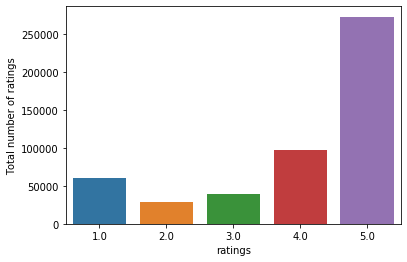

In [13]:
# Check the distribution of the rating
sns.countplot(x = 'ratings', data = electronics_df1)
plt.ylabel('Total number of ratings')

Most of the people has given the rating of 5

In [14]:
electronics_df1['userId'].nunique() #Unique UserID`s

404347

In [15]:
electronics_df1['productId'].nunique()# Unique ProductId`s

30667

# Taking the subset of dataset to make it less sparse/ denser.

In [16]:
# Top 50 users based on number of ratings given (no. of places visited)
most_rated = electronics_df1.groupby('userId').size().sort_values(ascending=False)[:50]
most_rated
#or electronics_df['userId'].value_counts()[0:50]

userId
A5JLAU2ARJ0BO     296
A231WM2Z2JL0U3    247
A25HBO5V8S8SEA    155
AKT8TGIT6VVZ5      86
AT6CZDCP4TRGA      79
A11D1KHM7DVOQK     78
A6FIAB28IS79       78
A2AEZQ3DGBBLPR     77
A2B7BUH8834Y6M     74
ABH9D1TEOJ56E      64
A1MJMYLRTZ76ZX     58
A12DLJESJKM1OQ     57
A2R6RA8FRBS608     57
AT2J7H5TRZM8Z      57
AGHZXQL9F94T9      56
A203OCQQ12MAVT     56
A2BGZ52M908MJY     54
A1RPTVW5VEOSI      53
A7Y6AVS576M03      52
A1JWSDDIH5Z7DV     50
A1FR68QH6Z4YZM     45
A3OXHLG6DIBRW8     44
A1F9Z42CFF9IAY     43
A149RNR5RH19YY     43
A2AY4YUOX2N1BQ     42
A8TZ88OM8YOLW      42
ALUNVOQRXOZIA      42
A1KD8NJPZ01R37     39
AY8Q1X7G96HV5      37
AWPODHOB4GFWL      35
A2CL818RN52NWN     35
A2PSD2R9A1CXG7     35
A1522TN5FVJL0Y     33
AGXV8E7XK9J6H      32
ARXU3FESTWMJJ      32
A2XRMQA6PJ5ZJ8     32
A1435P5AMCPB3X     31
A1NVD0TKNS1GT5     31
A2G2QNKDL1Y6AC     31
A6VXZ1EEPRTLV      31
A1JJOV69MAU2J2     31
A242IFN64X6R4E     30
A1IANEBSMVGHS9     30
A3OA4DV4L81N1D     30
ASCM3206SVTO0      30
A38

In [17]:
counts = electronics_df1['userId'].value_counts()
df_final = electronics_df1[electronics_df1['userId'].isin(counts[counts >= 50].index)]

In [18]:
df_final.head()

,userId,productId,ratings
2162,A5JLAU2ARJ0BO,1400532655,1.0
7381,A2AEZQ3DGBBLPR,B000000O48,5.0
7448,A2R6RA8FRBS608,B000001OL6,4.0
7789,A11D1KHM7DVOQK,B000001OMN,2.0
8732,A6FIAB28IS79,B00000J05A,3.0


In [19]:
df_final.shape

(1784, 3)

In [20]:
df_final['productId'].nunique()

1559

# Calculate the density of the rating matrix

In [21]:
final_ratings_matrix = df_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings) # beacuse 0 is NA

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1] # will include 0's 
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density)) 

Shape of final_ratings_matrix:  (20, 1559)
given_num_of_ratings =  1784
possible_num_of_ratings =  31180
density: 5.72%


# Popularity Based Recommendation
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [22]:
#Total no of rating for product

df_final.groupby('productId')['userId'].count().sort_values(ascending=False).head()

productId
B00004SB92    5
B00008OE6I    4
B00008OE5G    4
B00007KDVI    3
B00006JKXN    3
Name: userId, dtype: int64

In [23]:
df_final.groupby('productId')['ratings'].count()

productId
1400532655    1
B000000O48    1
B000001OL6    1
B000001OMN    1
B00000J05A    1
             ..
B0002OD3JY    2
B0002OG6NY    1
B0002OG6OI    1
B0002OG6PM    1
B0002OIWZE    1
Name: ratings, Length: 1559, dtype: int64

In [24]:
ratings_mean_count = pd.DataFrame(df_final.groupby('productId')['userId'].count().reset_index())
ratings_mean_count.rename(columns = {'userId': 'score'},inplace=True)

In [25]:
ratings_mean_count

,productId,score
0,1400532655,1
1,B000000O48,1
2,B000001OL6,1
3,B000001OMN,1
4,B00000J05A,1
...,...,...
1554,B0002OD3JY,2
1555,B0002OG6NY,1
1556,B0002OG6OI,1
1557,B0002OG6PM,1


In [26]:
ratings_mean_count['score'].value_counts()

1    1361
2     175
3      20
4       2
5       1
Name: score, dtype: int64

In [27]:
most_popular = ratings_mean_count.sort_values('score', ascending=False)

In [28]:
most_popular

,productId,score
100,B00004SB92,5
1007,B00008OE5G,4
1009,B00008OE6I,4
558,B0000645C8,3
787,B00006IR39,3
...,...,...
550,B000063SGW,1
549,B000063SAT,1
548,B000063S4J,1
547,B000063S4I,1


In [29]:
#Sort the products on recommendation score 
popular = most_popular.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
popular['rank'] = popular['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = popular.head(5) 
popularity_recommendations

,productId,score,rank
100,B00004SB92,5,1.0
1007,B00008OE5G,4,2.0
1009,B00008OE6I,4,3.0
262,B000050AQ7,3,4.0
300,B000056SSM,3,5.0


In [30]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    #print(cols)
    cols = cols[-1:] + cols[:-1] #moving userID as the 1st column
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [31]:
recommend(228) # Example shown as recommendation

,userID,productId,score,rank
100,228,B00004SB92,5,1.0
1007,228,B00008OE5G,4,2.0
1009,228,B00008OE6I,4,3.0
262,228,B000050AQ7,3,4.0
300,228,B000056SSM,3,5.0


Since this is a popularity-based recommender model, recommendations remain the same for all users
We predict the products based on the popularity. It is not personalized to particular user

# Build Collaborative Filtering model (Personalised)

Collaberative filtering (Item-Item recommedation)

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

## Model-based collaborative filtering system
These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices

In [32]:
df_CF = df_final

In [33]:
df_CF

,userId,productId,ratings
2162,A5JLAU2ARJ0BO,1400532655,1.0
7381,A2AEZQ3DGBBLPR,B000000O48,5.0
7448,A2R6RA8FRBS608,B000001OL6,4.0
7789,A11D1KHM7DVOQK,B000001OMN,2.0
8732,A6FIAB28IS79,B00000J05A,3.0
...,...,...,...
498801,AGHZXQL9F94T9,B0002OD3JY,4.0
499148,A1JWSDDIH5Z7DV,B0002OG6NY,5.0
499177,A1JWSDDIH5Z7DV,B0002OG6OI,5.0
499200,A1JWSDDIH5Z7DV,B0002OG6PM,5.0


In [34]:
df_CF['userId'].nunique()

20

In [35]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
# in popularity based, item will be in index, and here user will be in index
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.shape
pivot_df.head()

(20, 1559)

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002MQ76C,B0002MQGOK,B0002MRO14,B0002MRO2S,B0002MSTW2,B0002OD3JY,B0002OG6NY,B0002OG6OI,B0002OG6PM,B0002OIWZE
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
A1JWSDDIH5Z7DV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0],1)
pivot_df.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002MQGOK,B0002MRO14,B0002MRO2S,B0002MSTW2,B0002OD3JY,B0002OG6NY,B0002OG6OI,B0002OG6PM,B0002OIWZE,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1
A1JWSDDIH5Z7DV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,2
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [37]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002MQ76C,B0002MQGOK,B0002MRO14,B0002MRO2S,B0002MSTW2,B0002OD3JY,B0002OG6NY,B0002OG6OI,B0002OG6PM,B0002OIWZE
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
pivot_df.shape  

(20, 1559)

# SVDS method-In linear algebra, the Singular Value Decomposition (SVD) of a matrix is a factorization of that matrix into three matrices.

In [39]:
from scipy.sparse.linalg import svds

In [40]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 18) # k is the concept
# Construct diagonal array in SVD
#print(sigma)
sigma = np.diag(sigma) # convert python resultant sigma array to sigma diagonal matrix 
#print(sigma)

In [41]:
U.shape, sigma.shape, Vt.shape

((20, 18), (18, 18), (18, 1559))

In [42]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-9.53911320e-01  6.21893442e-02 -2.59287245e-01  2.88296432e-02
   1.08363539e-03 -1.24039503e-01  2.10012943e-02  8.99226506e-03
   6.19903005e-03 -3.01570096e-03 -6.29130280e-03  3.42863075e-02
   2.51100821e-02 -1.31801360e-03  8.02291552e-04 -2.07548774e-04
  -8.36171336e-03  1.01999556e-02]
 [-1.15854021e-02  5.49784538e-04  5.08675267e-03 -9.06516270e-02
   2.10690874e-03 -7.00398228e-03  8.90530346e-03  2.34339888e-03
   2.95496851e-03  1.62587704e-01  7.22835231e-01  3.59725520e-02
  -4.33882436e-02 -9.68157440e-02  1.41627867e-03  4.86585310e-03
  -1.00712048e-03  3.99110209e-02]
 [-2.05585595e-02 -1.12265751e-02  8.38954463e-02 -8.11507437e-02
  -2.52566720e-02 -9.81162355e-03  3.01159929e-01 -9.05726312e-01
   1.30450353e-01  1.19564792e-01 -5.61651183e-02  1.74377097e-01
  -4.82514543e-02 -8.09454953e-02 -2.59984504e-03  3.00497274e-03
   9.27803075e-03  1.06534121e-02]
 [-1.85250881e-02 -1.45166354e-01  4.00493924e-02  8.92559479e-03
   1.49063432

In [43]:
print('Sigma: \n',sigma)

Sigma: 
 [[28.97585466  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.         30.48464831  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         30.73725197  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         30.78908066  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         31.39535405  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.  

In [44]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 3.78270550e-04  4.67915604e-03  1.62359534e-02 ... -3.54753290e-03
  -3.54753290e-03  3.78270550e-04]
 [-6.96295576e-05  5.63153540e-04  1.01992167e-03 ... -1.84134896e-03
  -1.84134896e-03 -6.96295576e-05]
 [ 1.21451444e-04  4.44262009e-03  7.17569570e-03 ...  1.36471937e-02
   1.36471937e-02  1.21451444e-04]
 ...
 [-2.33327090e-04  7.43350869e-04  8.99471537e-05 ...  2.42787941e-04
   2.42787941e-04 -2.33327090e-04]
 [-8.35602147e-03  1.60670471e-03  1.41946772e-04 ...  6.89252013e-04
   6.89252013e-04 -8.35602147e-03]
 [ 1.11018915e-02  2.47401119e-03  4.46038815e-04 ...  7.17795975e-04
   7.17795975e-04  1.11018915e-02]]


In [45]:
#predicted = dot product of all the three matrices
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # A = U.simga.Vt
#print(all_user_predicted_ratings)
# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns) # cols are restaurants/terms
preds_df

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002MQ76C,B0002MQGOK,B0002MRO14,B0002MRO2S,B0002MSTW2,B0002OD3JY,B0002OG6NY,B0002OG6OI,B0002OG6PM,B0002OIWZE
0,0.000079,-0.000237,-0.000060,1.999708,0.000069,0.003676,-0.000351,-0.000047,-0.000060,0.999854,...,-0.000060,-0.000033,0.000236,0.000236,0.000393,-0.029522,-0.000531,-0.000531,-0.000531,0.000079
1,-0.009569,-0.039818,0.001281,0.007800,0.012990,-0.319336,-0.006009,-0.007964,0.001281,0.003900,...,0.001281,0.000875,-0.028706,-0.028706,-0.047843,2.864176,0.022236,0.022236,0.022236,-0.009569
2,0.000094,0.000058,-0.000042,-0.000212,-0.000024,0.003771,-0.000178,0.000012,-0.000042,-0.000106,...,-0.000042,-0.000024,0.000283,0.000283,0.000471,-0.011856,4.999574,4.999574,4.999574,0.000094
3,0.000251,0.003994,0.000223,0.000989,-0.001260,0.002885,0.002250,0.000799,0.000223,0.000494,...,0.000223,0.000112,0.000754,0.000754,0.001257,0.232925,0.001236,0.001236,0.001236,0.000251
4,-0.001415,-0.005104,0.000258,0.001471,0.001676,4.951321,-0.000332,-0.001021,0.000258,0.000735,...,0.000258,0.000165,-0.004244,-0.004244,-0.007074,-0.113947,0.003771,0.003771,0.003771,-0.001415
5,0.000004,-0.000011,-0.000003,-0.000013,0.000003,0.000165,-0.000016,-0.000002,-0.000003,-0.000007,...,-0.000003,4.999999,0.000011,0.000011,0.000018,-0.001333,-0.000024,-0.000024,-0.000024,0.000004
6,-0.000245,-0.000074,0.000115,0.000583,0.000038,-0.009955,0.000518,-0.000015,0.000115,0.000292,...,0.000115,0.000066,-0.000736,-0.000736,-0.001226,0.036129,0.001155,0.001155,0.001155,-0.000245
7,-0.000011,0.000442,0.000044,0.000208,-0.000137,-0.001298,0.000340,0.000088,0.000044,0.000104,...,0.000044,0.000023,-0.000034,-0.000034,-0.000057,0.032379,0.000329,0.000329,0.000329,-0.000011
8,-0.000187,4.998611,-0.000028,-0.000095,0.000444,-0.005104,-0.000551,0.999722,-0.000028,-0.000047,...,-0.000028,-0.000011,-0.000561,-0.000561,-0.000935,-0.064269,0.000058,0.000058,0.000058,-0.000187
9,-0.000291,-0.000694,0.000084,0.000447,0.000234,-0.010689,0.000185,-0.000139,0.000084,0.000224,...,0.000084,0.000050,-0.000874,-0.000874,-0.001457,0.001104,0.000997,0.000997,0.000997,-0.000291


In [46]:
# Recommend the items with the highest predicted ratings

def recommend_items(userId, pivot_df, preds_df, num_recommendations):
      
    user_idx = userId-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False) #user_idx is the row number
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   # why 0? because these are the products the user has not rated, so we 
    # have to recommend from these to him
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userId))
    print(temp.head(num_recommendations)) 

In [47]:
# Enter 'userId' and 'num_recommendations' for the user 
userId = 1
num_recommendations = 5
recommend_items(userId, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                   user_ratings  user_predictions
Recommended Items                                
B00006RSJ1                  0.0          0.022332
B00006LS92                  0.0          0.020375
B00006L9CT                  0.0          0.019893
B000087L74                  0.0          0.019814
B00008W7LL                  0.0          0.019814


In [48]:
# Average PREDICTED rating for each item
preds_df.mean()

productId
1400532655    0.050149
B000000O48    0.249499
B000001OL6    0.199882
B000001OMN    0.099424
B00000J05A    0.150147
                ...   
B0002OD3JY    0.340373
B0002OG6NY    0.248960
B0002OG6OI    0.248960
B0002OG6PM    0.248960
B0002OIWZE    0.050149
Length: 1559, dtype: float64

In [49]:
rmse_df = pd.concat([pivot_df.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)

rmse_df.head()

(1559, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.05,0.050149,0
B000000O48,0.25,0.249499,1
B000001OL6,0.20,0.199882,2
B000001OMN,0.10,0.099424,3
B00000J05A,0.15,0.150147,4


In [50]:
#Bring user_id column to the front 
cols = rmse_df.columns.tolist() 
    #print(cols)
cols = cols[-1:] + cols[:-1] #moving userID as the 1st column
rmse_df = rmse_df[cols] 

In [51]:
# Finding Optimal Value of K 
from sklearn.metrics import mean_squared_error
cl2=[5,7,9,11,13,15,16,17,18,19]
svd_a=[]
svd_rmse=[]
for a in cl2:
    rmse_df=pd.DataFrame()
    # Singular Value Decomposition
    U, sigma, Vt = svds(pivot_df, k = a) # k is the concept
# Construct diagonal array in SVD
#print(sigma)
    sigma = np.diag(sigma) # convert python resultant sigma array to sigma diagonal matrix 
#print(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # A = U.simga.Vt
#print(all_user_predicted_ratings)
# Predicted ratings
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns) 
    rmse_df = pd.concat([pivot_df.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
    svd_rmse.append((mean_squared_error(rmse_df.Avg_actual_ratings,rmse_df.Avg_predicted_ratings))**0.5)
    svd_a.append(a)

In [52]:
df_resa=pd.DataFrame(svd_a,columns=['K-Value'])
df_resa['RMSE']=svd_rmse
df_resa

,K-Value,RMSE
0,5,0.153158
1,7,0.121335
2,9,0.100712
3,11,0.093289
4,13,0.072702
5,15,0.064686
6,16,0.055533
7,17,0.024350
8,18,0.015068
9,19,0.015067


In [53]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01507 



### Optimal Value Seems to be 18

In [54]:
rmse_df

,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.05,0.050152,0
B000000O48,0.25,0.249517,1
B000001OL6,0.20,0.199882,2
B000001OMN,0.10,0.099423,3
B00000J05A,0.15,0.150141,4
...,...,...,...
B0002OD3JY,0.40,0.341123,1554
B0002OG6NY,0.25,0.248956,1555
B0002OG6OI,0.25,0.248956,1556


# TruncatedSVD

## Truncated Singular Value Decomposition (SVD) is a matrix factorization technique that factors a matrix M into the three matrices U, Σ, and V.

## Truncated SVD is different from regular SVDs in that it produces a factorization where the number of columns is equal to the specified truncation. For example, given an n x n matrix, SVD will produce matrices with n columns, whereas truncated SVD will produce matrices with the specified number of columns. This is how the dimensionality is reduced.

In [55]:
X = preds_df.T

In [56]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
productId,,,,,,,,,,,,,,,,,,,,
1400532655,0.000077,-0.002031,0.000056,-0.000263,-0.000384,0.000003,-0.000154,-0.000055,0.000026,-0.000117,0.000092,0.000008,0.999959,-0.000013,0.000037,0.000613,0.005976,0.000010,-0.000272,-0.000522
B000000O48,-0.000245,0.006437,-0.000177,0.000835,0.001219,-0.000011,0.000488,0.000175,4.999918,0.000372,-0.000292,-0.000025,0.000129,0.000040,-0.000119,-0.001944,-0.018946,-0.000033,0.000863,0.001656
B000001OL6,-0.000060,0.001569,-0.000043,0.000204,0.000297,-0.000003,0.000119,0.000043,-0.000020,0.000091,-0.000071,3.999994,0.000032,0.000010,-0.000029,-0.000474,-0.004618,-0.000008,0.000210,0.000404
B000001OMN,1.999708,0.007684,-0.000212,0.000997,0.001455,-0.000013,0.000582,0.000208,-0.000098,0.000445,-0.000349,-0.000030,0.000155,0.000048,-0.000141,-0.002321,-0.022615,-0.000039,0.001030,0.001976
B00000J05A,0.000072,-0.001886,0.000052,-0.000245,-0.000357,0.000003,-0.000143,-0.000051,0.000024,-0.000109,0.000086,0.000007,-0.000038,2.999988,0.000035,0.000569,0.005550,0.000010,-0.000253,-0.000485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0002OD3JY,-0.029862,4.784702,-0.021623,0.101778,0.148561,-0.001345,0.059439,0.021278,-0.010007,0.045396,-0.035639,-0.003049,0.015783,0.004886,-0.014446,-0.236979,1.690539,-0.003966,0.105200,0.201812
B0002OG6NY,-0.000529,0.013910,4.999617,0.001804,0.002633,-0.000024,0.001054,0.000377,-0.000177,0.000805,-0.000632,-0.000054,0.000280,0.000087,-0.000256,-0.004201,-0.040939,-0.000070,0.001865,0.003577
B0002OG6OI,-0.000529,0.013910,4.999617,0.001804,0.002633,-0.000024,0.001054,0.000377,-0.000177,0.000805,-0.000632,-0.000054,0.000280,0.000087,-0.000256,-0.004201,-0.040939,-0.000070,0.001865,0.003577


In [57]:
n_components=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
explained_variance=[]
for n in n_components:
    svd=TruncatedSVD(n_components=n,random_state=42)
    svd.fit(X)
    exvar=svd.explained_variance_ratio_.sum()
    explained_variance.append(exvar)
    
    print('n_components=',n,'variance=',exvar)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5, random_state=42,
             tol=0.0)

n_components= 5 variance= 0.493643754328029


TruncatedSVD(algorithm='randomized', n_components=6, n_iter=5, random_state=42,
             tol=0.0)

n_components= 6 variance= 0.54124732949538


TruncatedSVD(algorithm='randomized', n_components=7, n_iter=5, random_state=42,
             tol=0.0)

n_components= 7 variance= 0.5824533673989645


TruncatedSVD(algorithm='randomized', n_components=8, n_iter=5, random_state=42,
             tol=0.0)

n_components= 8 variance= 0.6277923849865181


TruncatedSVD(algorithm='randomized', n_components=9, n_iter=5, random_state=42,
             tol=0.0)

n_components= 9 variance= 0.6703108181039767


TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5, random_state=42,
             tol=0.0)

n_components= 10 variance= 0.7109327492664868


TruncatedSVD(algorithm='randomized', n_components=11, n_iter=5, random_state=42,
             tol=0.0)

n_components= 11 variance= 0.7511569231788299


TruncatedSVD(algorithm='randomized', n_components=12, n_iter=5, random_state=42,
             tol=0.0)

n_components= 12 variance= 0.7883895955114635


TruncatedSVD(algorithm='randomized', n_components=13, n_iter=5, random_state=42,
             tol=0.0)

n_components= 13 variance= 0.8239438216931813


TruncatedSVD(algorithm='randomized', n_components=14, n_iter=5, random_state=42,
             tol=0.0)

n_components= 14 variance= 0.8564047226076943


TruncatedSVD(algorithm='randomized', n_components=15, n_iter=5, random_state=42,
             tol=0.0)

n_components= 15 variance= 0.8871536377286049


TruncatedSVD(algorithm='randomized', n_components=16, n_iter=5, random_state=42,
             tol=0.0)

n_components= 16 variance= 0.9173319562835073


TruncatedSVD(algorithm='randomized', n_components=17, n_iter=5, random_state=42,
             tol=0.0)

n_components= 17 variance= 0.9466702286196129


TruncatedSVD(algorithm='randomized', n_components=18, n_iter=5, random_state=42,
             tol=0.0)

n_components= 18 variance= 0.97405450418543


TruncatedSVD(algorithm='randomized', n_components=19, n_iter=5, random_state=42,
             tol=0.0)

n_components= 19 variance= 1.0000000000000007


Text(0.5, 0, 'n_components')

Text(0, 0.5, 'Explained variance')

Text(0.5, 1.0, 'n_components v/s Explained variance')

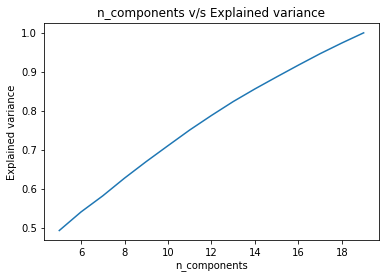

In [58]:
#plotting curve between n_components and explained variance
plt.plot(n_components, explained_variance)
plt.xlabel('n_components')
plt.ylabel("Explained variance")
plt.title("n_components v/s Explained variance")
plt.show() 

In [59]:

SVD1 = TruncatedSVD(n_components=16,random_state=42)
decomposed_matrix = SVD1.fit_transform(X)
decomposed_matrix.shape

(1559, 16)

In [60]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1559, 1559)

In [61]:
X.index[75] # Index # of product ID purchased by customer

'B00003G1RG'

In [62]:
i = "B000001OL6"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

2

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [63]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1559,)

In [64]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['B00000J1EP', 'B00000J4IX', 'B00001ZT4H', 'B00003GO0E', 'B00004SU73']

# KNN MEANS -USER AND ITEM BASED

KNN is a machine learning algorithm to find clusters of similar users and items based on common ratings, and make predictions using the average rating of top-k nearest neighbors.

In [65]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split 

In [66]:
#Reading the dataset 
reader = Reader(rating_scale=(1, 6))
data = Dataset.load_from_df(df_final,reader)

In [67]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=90)

## ITEM BASED- SIMILARITY:PEARSON

In [68]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=55,min_k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset) 

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [69]:
test_pred = algo.test(testset)
test_pred
 

[Prediction(uid='A5JLAU2ARJ0BO', iid='B0001MHL0Y', r_ui=3.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0000YB7RQ', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AGHZXQL9F94T9', iid='B00008J6VW', r_ui=3.0, est=5.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004WEJX', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00007E83S', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00020VX9K', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A11D1KHM7DVOQK', iid='B000083K05', r_ui=4.0, est=4.16826923

In [70]:
def precision_recall_at_k(predictions, k=45, threshold=3):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [71]:
from collections import defaultdict
precisions_test, recalls_test = precision_recall_at_k(test_pred,k=55, threshold=3)
precisions_test

{'A5JLAU2ARJ0BO': 0.8181818181818182,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 0.46153846153846156,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.6818181818181818,
 'A231WM2Z2JL0U3': 0.9818181818181818,
 'A1RPTVW5VEOSI': 0.9285714285714286,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.75,
 'A12DLJESJKM1OQ': 0.9375,
 'A2AEZQ3DGBBLPR': 0.8636363636363636,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 0.7777777777777778,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 0.9444444444444444,
 'A6FIAB28IS79': 0.9090909090909091,
 'AT2J7H5TRZM8Z': 0.9333333333333333,
 'A1JWSDDIH5Z7DV': 1.0}

In [72]:
from collections import defaultdict
precisions_test, recalls_test = precision_recall_at_k(test_pred,k=55, threshold=3)
precisions_test

{'A5JLAU2ARJ0BO': 0.8181818181818182,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 0.46153846153846156,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.6818181818181818,
 'A231WM2Z2JL0U3': 0.9818181818181818,
 'A1RPTVW5VEOSI': 0.9285714285714286,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.75,
 'A12DLJESJKM1OQ': 0.9375,
 'A2AEZQ3DGBBLPR': 0.8636363636363636,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 0.7777777777777778,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 0.9444444444444444,
 'A6FIAB28IS79': 0.9090909090909091,
 'AT2J7H5TRZM8Z': 0.9333333333333333,
 'A1JWSDDIH5Z7DV': 1.0}

FINDING OPTIMAL VALUE OF K

In [73]:
ac_scores = []

In [74]:
neighbors=list(range(31,58,2))
for k in neighbors:
    precisions_test, recalls_test = precision_recall_at_k(test_pred,k=k, threshold=3)
    c=(sum(prec for prec in precisions_test.values()) / len(precisions_test))
    ac_scores.append(c)
    print('Neighbors:', k,' Precision:', c)


Neighbors: 31  Precision: 0.9013210288815128
Neighbors: 33  Precision: 0.9018097874347875
Neighbors: 35  Precision: 0.902242687867688
Neighbors: 37  Precision: 0.9026287882537882
Neighbors: 39  Precision: 0.9016932373182375
Neighbors: 41  Precision: 0.9020684718398133
Neighbors: 43  Precision: 0.9000832194291497
Neighbors: 45  Precision: 0.899385545010545
Neighbors: 47  Precision: 0.8998110769254387
Neighbors: 49  Precision: 0.8991814633778921
Neighbors: 51  Precision: 0.8995816234419175
Neighbors: 53  Precision: 0.8999515827463942
Neighbors: 55  Precision: 0.899385545010545
Neighbors: 57  Precision: 0.8988592292210713


In [75]:
for k in neighbors:
    precisions_test, recalls_test = precision_recall_at_k(test_pred,k=k, threshold=3)
    d=(sum(prec for prec in recalls_test.values()) / len(recalls_test))
    ac_scores.append(d) 
    print('Neighbors:', k,' Recall:', d)

Neighbors: 31  Recall: 0.9092117041136566
Neighbors: 33  Recall: 0.9139609709758266
Neighbors: 35  Recall: 0.9187102378379969
Neighbors: 37  Recall: 0.9234595047001669
Neighbors: 39  Recall: 0.9274023199494337
Neighbors: 41  Recall: 0.9321515868116037
Neighbors: 43  Recall: 0.9352879504479674
Neighbors: 45  Recall: 0.9394690354919557
Neighbors: 47  Recall: 0.9442183023541257
Neighbors: 49  Recall: 0.9481611176033926
Neighbors: 51  Recall: 0.9519103844655629
Neighbors: 53  Recall: 0.9546596513277329
Neighbors: 55  Recall: 0.9566024665769997
Neighbors: 57  Recall: 0.9585452818262666


In [76]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    #'''Return the top-N recommendation for each user from a set of predictions.
   # Args:
       # predictions(list of Prediction objects): The list of predictions, as
           # returned by the test method of an algorithm.
       # n(int): The number of recommendation to output for each user. Default
           # is 10.
   # Returns:
   # A dict where keys are user (raw) ids and values are lists of tuples:
       # [(raw item id, rating estimation), ...] of size n.


# First map the predictions to each user.
     top_n = defaultdict(list)

     for uid, iid, true_r, est, _ in test_pred:
        top_n[uid].append((iid, est))
 # Then sort the predictions for each user and retrieve the k highest ones.
     for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
     return top_n
    

In [77]:
get_top_n(test_pred, n=5)

defaultdict(list,
            {'A5JLAU2ARJ0BO': [('B00004Z5M1', 5.0),
              ('B00006HYKM', 5.0),
              ('B00008WFVI', 5.0),
              ('B00004SB92', 4.666666666666667),
              ('B0001MHL0Y', 4.168269230769231)],
             'A2B7BUH8834Y6M': [('B0000YB7RQ', 4.168269230769231),
              ('B00007E83S', 4.168269230769231),
              ('B000059YXK', 4.168269230769231),
              ('B00000J1UU', 4.168269230769231),
              ('B000068BSC', 4.168269230769231)],
             'AGHZXQL9F94T9': [('B00008J6VW', 5.0),
              ('B000087KY8', 5.0),
              ('B00008J639', 5.0),
              ('B0000645C9', 5.0),
              ('B00006JP3Q', 4.168269230769231)],
             'A1MJMYLRTZ76ZX': [('B00008K4BD', 4.5),
              ('B00004WEJX', 4.168269230769231),
              ('B00005Y1Z6', 4.168269230769231),
              ('B00006I5BN', 4.168269230769231),
              ('B00004TX7E', 4.168269230769231)],
             'A11D1KHM7DVOQK': [('B0000E

In [78]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1886


1.1885870301748558

In [79]:
from collections import defaultdict
precisions_test, recalls_test = precision_recall_at_k(test_pred,k=55, threshold=3)
precisions_test

{'A5JLAU2ARJ0BO': 0.8181818181818182,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 0.46153846153846156,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.6818181818181818,
 'A231WM2Z2JL0U3': 0.9818181818181818,
 'A1RPTVW5VEOSI': 0.9285714285714286,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.75,
 'A12DLJESJKM1OQ': 0.9375,
 'A2AEZQ3DGBBLPR': 0.8636363636363636,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 0.7777777777777778,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 0.9444444444444444,
 'A6FIAB28IS79': 0.9090909090909091,
 'AT2J7H5TRZM8Z': 0.9333333333333333,
 'A1JWSDDIH5Z7DV': 1.0}

In [80]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions_test.values()) / len(precisions_test))


0.899385545010545


In [81]:
recalls_test

{'A5JLAU2ARJ0BO': 0.7258064516129032,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 1.0,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 1.0,
 'A231WM2Z2JL0U3': 0.6136363636363636,
 'A1RPTVW5VEOSI': 0.9285714285714286,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.9473684210526315,
 'A12DLJESJKM1OQ': 1.0,
 'A2AEZQ3DGBBLPR': 1.0,
 'A2R6RA8FRBS608': 0.9166666666666666,
 'A2BGZ52M908MJY': 1.0,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 1.0,
 'A6FIAB28IS79': 1.0,
 'AT2J7H5TRZM8Z': 1.0,
 'A1JWSDDIH5Z7DV': 1.0}

In [82]:
# Precision and recall can then be averaged over all users
print(sum(rec for rec in recalls_test.values()) / len(recalls_test))

0.9566024665769997


In [83]:
cross_validate(algo,data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0919  1.2241  1.2022  1.4164  1.2426  1.2354  0.1045  
MAE (testset)     0.8526  0.9288  0.9314  1.0728  0.9583  0.9488  0.0713  
Fit time          0.10    0.11    0.08    0.08    0.10    0.09    0.01    
Test time         0.01    0.01    0.01    0.01    0.

{'test_rmse': array([1.09192598, 1.22405264, 1.20223411, 1.41644208, 1.24256743]),
 'test_mae': array([0.85262253, 0.92879013, 0.93139218, 1.07275241, 0.95827432]),
 'fit_time': (0.09990882873535156,
  0.10723400115966797,
  0.07628583908081055,
  0.08296608924865723,
  0.10124015808105469),
 'test_time': (0.00959014892578125,
  0.010482072830200195,
  0.007844924926757812,
  0.010186910629272461,
  0.00939798355102539)}

## ITEM BASED-SIMILARITY:COSINE

In [84]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
from surprise import KNNBaseline
algo_cos = KNNWithMeans(k=55, sim_options={'name': 'cosine', 'user_based': False})
algo_cos.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [85]:
# run the trained model against the testset
test_pred_cos = algo_cos.test(testset)

In [86]:
test_pred_cos

[Prediction(uid='A5JLAU2ARJ0BO', iid='B0001MHL0Y', r_ui=3.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0000YB7RQ', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AGHZXQL9F94T9', iid='B00008J6VW', r_ui=3.0, est=4.583333333333333, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004WEJX', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00007E83S', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00020VX9K', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A11D1KHM7DVOQK', iid='B000083K05', r_ui=4.0, 

In [87]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_cos, verbose=True)

Item-based Model : Test Set
RMSE: 1.1822


1.1822276892931416

In [88]:
precisions_test_cos, recalls_test_cos = precision_recall_at_k(test_pred_cos, k=55, threshold=3)
precisions_test_cos

{'A5JLAU2ARJ0BO': 0.8363636363636363,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 0.46153846153846156,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.6666666666666666,
 'A231WM2Z2JL0U3': 0.9636363636363636,
 'A1RPTVW5VEOSI': 0.9285714285714286,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.75,
 'A12DLJESJKM1OQ': 0.9375,
 'A2AEZQ3DGBBLPR': 0.8636363636363636,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 0.8235294117647058,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 0.9444444444444444,
 'A6FIAB28IS79': 0.9090909090909091,
 'AT2J7H5TRZM8Z': 0.9333333333333333,
 'A1JWSDDIH5Z7DV': 1.0}

In [89]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions_test_cos.values()) / len(precisions_test_cos))

0.9009155509523158


In [90]:
recalls_test_cos

{'A5JLAU2ARJ0BO': 0.7419354838709677,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 1.0,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.9333333333333333,
 'A231WM2Z2JL0U3': 0.6022727272727273,
 'A1RPTVW5VEOSI': 0.9285714285714286,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.9473684210526315,
 'A12DLJESJKM1OQ': 1.0,
 'A2AEZQ3DGBBLPR': 1.0,
 'A2R6RA8FRBS608': 0.9166666666666666,
 'A2BGZ52M908MJY': 1.0,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 1.0,
 'A6FIAB28IS79': 1.0,
 'AT2J7H5TRZM8Z': 1.0,
 'A1JWSDDIH5Z7DV': 1.0}

In [91]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in recalls_test_cos.values()) / len(recalls_test_cos))

0.9535074030383879


In [92]:
#Cross Validation
cross_validate(algo_cos,data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1770  1.2470  1.2780  1.1911  1.2454  1.2277  0.0378  
MAE (testset)     0.8925  0.9713  0.9833  0.9367  0.9844  0.9537  0.0351  
Fit time          0.17    0.17    0.17    0.16    0.16    0.17    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.17703339, 1.24704427, 1.2779758 , 1.19106319, 1.24543566]),
 'test_mae': array([0.892509  , 0.97134071, 0.98330683, 0.93674159, 0.98440403]),
 'fit_time': (0.1711118221282959,
  0.16884231567382812,
  0.1654059886932373,
  0.16437482833862305,
  0.15941786766052246),
 'test_time': (0.01380300521850586,
  0.011836767196655273,
  0.010057926177978516,
  0.009376049041748047,
  0.00842905044555664)}

## USER BASED ,SIMILARITY: PEARSON

In [93]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo1 = KNNWithMeans(k=55, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo1.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [94]:
# run the trained model against the testset
test_pred1 = algo1.test(testset)

In [95]:
test_pred1

[Prediction(uid='A5JLAU2ARJ0BO', iid='B0001MHL0Y', r_ui=3.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0000YB7RQ', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AGHZXQL9F94T9', iid='B00008J6VW', r_ui=3.0, est=4.0294951786727164, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004WEJX', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00007E83S', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00020VX9K', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A11D1KHM7DVOQK', iid='B000083K05', r_ui=4.0,

In [96]:
get_top_n(test_pred1, n=5)

defaultdict(list,
            {'A5JLAU2ARJ0BO': [('B00004Z5M1', 5.0),
              ('B00006HYKM', 5.0),
              ('B00008WFVI', 5.0),
              ('B00004SB92', 4.666666666666667),
              ('B0001MHL0Y', 4.168269230769231)],
             'A2B7BUH8834Y6M': [('B0000YB7RQ', 4.168269230769231),
              ('B00007E83S', 4.168269230769231),
              ('B000059YXK', 4.168269230769231),
              ('B00000J1UU', 4.168269230769231),
              ('B000068BSC', 4.168269230769231)],
             'AGHZXQL9F94T9': [('B00008J6VW', 5.0),
              ('B000087KY8', 5.0),
              ('B00008J639', 5.0),
              ('B0000645C9', 5.0),
              ('B00006JP3Q', 4.168269230769231)],
             'A1MJMYLRTZ76ZX': [('B00008K4BD', 4.5),
              ('B00004WEJX', 4.168269230769231),
              ('B00005Y1Z6', 4.168269230769231),
              ('B00006I5BN', 4.168269230769231),
              ('B00004TX7E', 4.168269230769231)],
             'A11D1KHM7DVOQK': [('B0000E

In [97]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred1, verbose=True)

User-based Model : Test Set
RMSE: 1.1124


1.1123817736727144

In [98]:
precisions_test1, recalls_test1 = precision_recall_at_k(test_pred1, k=55, threshold=3)
precisions_test1

{'A5JLAU2ARJ0BO': 0.8363636363636363,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 0.46153846153846156,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.6111111111111112,
 'A231WM2Z2JL0U3': 0.9818181818181818,
 'A1RPTVW5VEOSI': 0.9333333333333333,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.76,
 'A12DLJESJKM1OQ': 0.9375,
 'A2AEZQ3DGBBLPR': 0.8636363636363636,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 0.8235294117647058,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 0.9444444444444444,
 'A6FIAB28IS79': 0.9090909090909091,
 'AT2J7H5TRZM8Z': 0.875,
 'A1JWSDDIH5Z7DV': 1.0}

In [99]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions_test1.values()) / len(precisions_test1))

0.8968682926550574


In [100]:
recalls_test1

{'A5JLAU2ARJ0BO': 0.7419354838709677,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 1.0,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.7333333333333333,
 'A231WM2Z2JL0U3': 0.6136363636363636,
 'A1RPTVW5VEOSI': 1.0,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 1.0,
 'A12DLJESJKM1OQ': 1.0,
 'A2AEZQ3DGBBLPR': 1.0,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 1.0,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 1.0,
 'A6FIAB28IS79': 1.0,
 'AT2J7H5TRZM8Z': 1.0,
 'A1JWSDDIH5Z7DV': 1.0}

In [101]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in recalls_test1.values()) / len(recalls_test1))

0.9544452590420333


In [102]:
cross_validate(algo1,data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1210  1.1303  1.1140  1.2616  1.1506  1.1555  0.0545  
MAE (testset)     0.8840  0.8827  0.8777  0.9728  0.9018  0.9038  0.0354  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.

{'test_rmse': array([1.1209599 , 1.13031087, 1.11397811, 1.26164907, 1.15060509]),
 'test_mae': array([0.88401386, 0.88274687, 0.87769653, 0.97277212, 0.90176675]),
 'fit_time': (0.009206056594848633,
  0.011105060577392578,
  0.007014274597167969,
  0.008591175079345703,
  0.008596181869506836),
 'test_time': (0.0028688907623291016,
  0.002660036087036133,
  0.0023097991943359375,
  0.0023488998413085938,
  0.0027267932891845703)}

## USER BASED- SIMILARITY : COSINE

In [103]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo12 = KNNWithMeans(k=55, sim_options={'name': 'cosine', 'user_based': True})
algo12.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [104]:
# run the trained model against the testset
test_pred12 = algo12.test(testset)
test_pred12

[Prediction(uid='A5JLAU2ARJ0BO', iid='B0001MHL0Y', r_ui=3.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0000YB7RQ', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AGHZXQL9F94T9', iid='B00008J6VW', r_ui=3.0, est=4.0294951786727164, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004WEJX', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00007E83S', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00020VX9K', r_ui=5.0, est=4.168269230769231, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A11D1KHM7DVOQK', iid='B000083K05', r_ui=4.0,

In [105]:
get_top_n(test_pred12, n=5)

defaultdict(list,
            {'A5JLAU2ARJ0BO': [('B00004Z5M1', 5.0),
              ('B00006HYKM', 5.0),
              ('B00008WFVI', 5.0),
              ('B00004SB92', 4.666666666666667),
              ('B0001MHL0Y', 4.168269230769231)],
             'A2B7BUH8834Y6M': [('B0000YB7RQ', 4.168269230769231),
              ('B00007E83S', 4.168269230769231),
              ('B000059YXK', 4.168269230769231),
              ('B00000J1UU', 4.168269230769231),
              ('B000068BSC', 4.168269230769231)],
             'AGHZXQL9F94T9': [('B00008J6VW', 5.0),
              ('B000087KY8', 5.0),
              ('B00008J639', 5.0),
              ('B0000645C9', 5.0),
              ('B00006JP3Q', 4.168269230769231)],
             'A1MJMYLRTZ76ZX': [('B00008K4BD', 4.5),
              ('B00004WEJX', 4.168269230769231),
              ('B00005Y1Z6', 4.168269230769231),
              ('B00006I5BN', 4.168269230769231),
              ('B00004TX7E', 4.168269230769231)],
             'A11D1KHM7DVOQK': [('B0000E

In [106]:
# get RMSE
print("User-based Model-COSINE : Test Set")
accuracy.rmse(test_pred12, verbose=True)

User-based Model-COSINE : Test Set
RMSE: 1.1660


1.1660298338108235

In [107]:
precisions_test12, recalls_test12 = precision_recall_at_k(test_pred12, k=55, threshold=3)
precisions_test12

{'A5JLAU2ARJ0BO': 0.8,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 0.46153846153846156,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.631578947368421,
 'A231WM2Z2JL0U3': 0.9818181818181818,
 'A1RPTVW5VEOSI': 0.9333333333333333,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 0.76,
 'A12DLJESJKM1OQ': 0.9375,
 'A2AEZQ3DGBBLPR': 0.8636363636363636,
 'A2R6RA8FRBS608': 1.0,
 'A2BGZ52M908MJY': 0.8235294117647058,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 0.9444444444444444,
 'A6FIAB28IS79': 0.9090909090909091,
 'AT2J7H5TRZM8Z': 0.9333333333333333,
 'A1JWSDDIH5Z7DV': 1.0}

In [108]:
recalls_test12

{'A5JLAU2ARJ0BO': 0.7096774193548387,
 'A2B7BUH8834Y6M': 1.0,
 'AGHZXQL9F94T9': 1.0,
 'A1MJMYLRTZ76ZX': 1.0,
 'A11D1KHM7DVOQK': 0.8,
 'A231WM2Z2JL0U3': 0.6136363636363636,
 'A1RPTVW5VEOSI': 1.0,
 'A25HBO5V8S8SEA': 1.0,
 'A7Y6AVS576M03': 1.0,
 'AT6CZDCP4TRGA': 1.0,
 'A12DLJESJKM1OQ': 1.0,
 'A2AEZQ3DGBBLPR': 1.0,
 'A2R6RA8FRBS608': 0.9166666666666666,
 'A2BGZ52M908MJY': 1.0,
 'AKT8TGIT6VVZ5': 1.0,
 'ABH9D1TEOJ56E': 1.0,
 'A203OCQQ12MAVT': 1.0,
 'A6FIAB28IS79': 1.0,
 'AT2J7H5TRZM8Z': 1.0,
 'A1JWSDDIH5Z7DV': 1.0}

In [109]:
cross_validate(algo12,data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1590  1.2377  1.1997  1.1561  1.2503  1.2006  0.0389  
MAE (testset)     0.9138  0.9482  0.9482  0.9026  0.9756  0.9377  0.0263  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.15899362, 1.23769838, 1.19970741, 1.15605169, 1.25033497]),
 'test_mae': array([0.91384398, 0.94821863, 0.94820003, 0.90263461, 0.97558868]),
 'fit_time': (0.0011980533599853516,
  0.0016570091247558594,
  0.0019347667694091797,
  0.003960132598876953,
  0.0013539791107177734),
 'test_time': (0.0031108856201171875,
  0.0031528472900390625,
  0.003595113754272461,
  0.0030400753021240234,
  0.002989053726196289)}

# KNN- Compressed Sparse Row matrix

We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [110]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
pivot_matrix = csr_matrix(pivot_df.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute',n_neighbors=55)
model_knn.fit(pivot_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=55, p=2,
                 radius=1.0)

In [111]:
query_index = np.random.choice(pivot_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(pivot_df.iloc[query_index,:].values.reshape(1, -1),n_neighbors=5)

4


In [112]:
pivot_df.index[query_index]

4

## In this step, the KNN algorithm measures distance to determine the “closeness” of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In [113]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(pivot_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, pivot_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 4:

1: 15, with distance of 0.9748727855352357:
2: 16, with distance of 0.975079695417192:
3: 2, with distance of 0.9768914416672958:
4: 6, with distance of 0.9788584390310681:


# SVD-The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.


## Function svd() computes some or all of the parts (singular values, left singular vectors and right singular vectors) of the singular valu decomposition (SVD) of a matrix

In [114]:
svd=SVD()

In [115]:
svd_model=svd.fit(trainset)

In [116]:
from surprise.model_selection import cross_validate

In [117]:
# run the trained model against the testset
test_pred3 = svd.test(testset)
test_pred3



[Prediction(uid='A5JLAU2ARJ0BO', iid='B0001MHL0Y', r_ui=3.0, est=3.935121626294582, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0000YB7RQ', r_ui=5.0, est=4.339274505896957, details={'was_impossible': False}),
 Prediction(uid='AGHZXQL9F94T9', iid='B00008J6VW', r_ui=3.0, est=3.401410041860938, details={'was_impossible': False}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004WEJX', r_ui=5.0, est=4.603296178259376, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00007E83S', r_ui=5.0, est=4.339274505896957, details={'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00020VX9K', r_ui=5.0, est=3.935121626294582, details={'was_impossible': False}),
 Prediction(uid='A11D1KHM7DVOQK', iid='B000083K05', r_ui=4.0, est=2.9765105697413685, details={'was_impossible': False}),
 Prediction(uid='A231WM2Z2JL0U3', iid='B00008J639', r_ui=4.0, est=4.39099129450712, details={'was_impossible': False}),
 Prediction(uid='AGHZXQL9F94T9', ii

In [118]:
# get RMSE
print("SVD Model : Test Set")
accuracy.rmse(test_pred3, verbose=True)

SVD Model : Test Set
RMSE: 1.0183


1.0183146139293822

In [119]:
get_top_n(test_pred3, n=5)

defaultdict(list,
            {'A5JLAU2ARJ0BO': [('B00004Z5M1', 5.0),
              ('B00006HYKM', 5.0),
              ('B00008WFVI', 5.0),
              ('B00004SB92', 4.666666666666667),
              ('B0001MHL0Y', 4.168269230769231)],
             'A2B7BUH8834Y6M': [('B0000YB7RQ', 4.168269230769231),
              ('B00007E83S', 4.168269230769231),
              ('B000059YXK', 4.168269230769231),
              ('B00000J1UU', 4.168269230769231),
              ('B000068BSC', 4.168269230769231)],
             'AGHZXQL9F94T9': [('B00008J6VW', 5.0),
              ('B000087KY8', 5.0),
              ('B00008J639', 5.0),
              ('B0000645C9', 5.0),
              ('B00006JP3Q', 4.168269230769231)],
             'A1MJMYLRTZ76ZX': [('B00008K4BD', 4.5),
              ('B00004WEJX', 4.168269230769231),
              ('B00005Y1Z6', 4.168269230769231),
              ('B00006I5BN', 4.168269230769231),
              ('B00004TX7E', 4.168269230769231)],
             'A11D1KHM7DVOQK': [('B0000E

In [120]:
cross_validate(svd_model,data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0559  1.0934  1.0633  1.0174  1.0295  1.0519  0.0267  
MAE (testset)     0.7793  0.7959  0.7759  0.7628  0.7864  0.7800  0.0110  
Fit time          0.11    0.09    0.09    0.09    0.09    0.10    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([1.05585262, 1.09337455, 1.06334307, 1.01737337, 1.02946694]),
 'test_mae': array([0.77929847, 0.79587821, 0.77590875, 0.76278118, 0.78635739]),
 'fit_time': (0.1052401065826416,
  0.09487199783325195,
  0.09316897392272949,
  0.09324884414672852,
  0.09250783920288086),
 'test_time': (0.0024781227111816406,
  0.0024268627166748047,
  0.0023190975189208984,
  0.002255678176879883,
  0.0022330284118652344)}

# CROSS VALIDATION OF THE AVAILABLE MODELS

In [121]:
import numpy as np
import six
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import KNNWithZScore







In [122]:
# KNN Based Algorithms
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)
knnbs_cv = cross_validate(KNNBaseline(), data, cv=5, n_jobs=5, verbose=False)



# Matrix Factorization Based Algorithms
nmf_cv=cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)

# Other Collaborative Filtering Algorithms
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)



In [123]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t',  round(knnz_cv['test_mae'].mean(), 4))
print('KNN Baseline', '\t', round(knnbs_cv['test_rmse'].mean(), 4), '\t', round(knnbs_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()
print('\nSVDS Model RMSE = {} \n'.format(RMSE))

Algorithm	 RMSE		 MAE

KNN Basic 	 1.2151 	 0.9412
KNN Means 	 1.1972 	 0.9359
KNN ZScore 	 1.1949 	 0.9292
KNN Baseline 	 1.1085 	 0.8331

SVD 		 1.0558 	 0.7823
SVDpp 		 1.0515 	 0.7785
NMF 		 1.2214 	 0.9637

SlopeOne 	 1.2124 	 0.9508
CoClustering 	 1.2408 	 0.9626


SVDS Model RMSE = 0.01507 



<Figure size 1440x360 with 0 Axes>

Text(0.5, 1.0, 'Comparison of Algorithms on RMSE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'RMSE Value')

Text(0.5, 1.0, 'Comparison of Algorithms on MAE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'MAE Value')

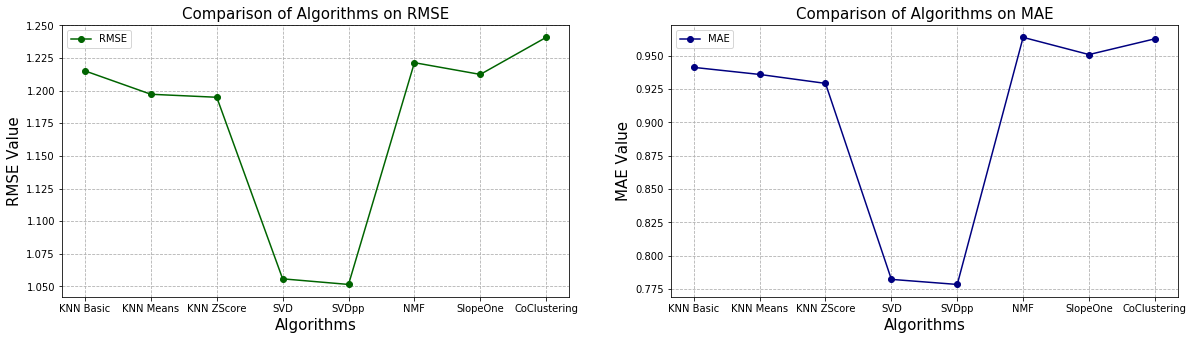

In [124]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

# Summarising insights.
The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.
Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.
SVD method gives an overall low RMSE and low MAE to give Recommendations.
